<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_1m_LSTM_CNC_without_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=c5bafb798bbb6e28ea522ef3c836899d2cf9d5371ed310a89183e188d218fa11
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [20]:
import yfinance as yf
one_m_data = yf.download(tickers='AAPL', period = '7d', interval = '1m')
one_m_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-10-15 09:30:00-04:00,143.770004,144.179993,143.750000,143.809998,143.809998,4820124
2021-10-15 09:31:00-04:00,143.800003,143.820007,143.570007,143.610001,143.610001,345726
2021-10-15 09:32:00-04:00,143.619995,143.850006,143.529999,143.600006,143.600006,351979
2021-10-15 09:33:00-04:00,143.801697,143.820007,143.774994,143.785004,143.785004,365111
2021-10-15 09:34:00-04:00,143.750000,143.880005,143.639999,143.720001,143.720001,349582
...,...,...,...,...,...,...
2021-10-25 12:14:00-04:00,148.730103,148.735001,148.634995,148.645004,148.645004,87815
2021-10-25 12:15:00-04:00,148.639999,148.649902,148.580002,148.585007,148.585007,122331
2021-10-25 12:16:00-04:00,148.580002,148.604996,148.554993,148.595001,148.595001,110455


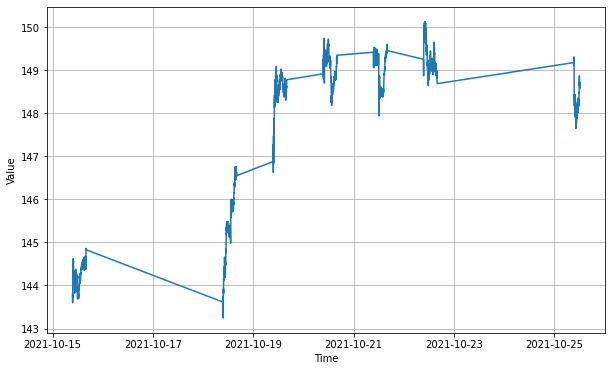

In [21]:
#from sklearn.preprocessing import StandardScaler

#series = one_d_data['Close'].values.reshape(-1, 1)
#scaler = StandardScaler()
#scaler.fit(series[:len(series) // 2])
#series = scaler.transform(series).flatten()

series = np.array(one_m_data.Close)
time = np.array(one_m_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [22]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [24]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2000,)
Epoch 1/100
8/8 [==============================] - 4s 54ms/step - loss: 125.4896 - mae: 125.9896
Epoch 2/100
8/8 [==============================] - 1s 54ms/step - loss: 123.7689 - mae: 124.2689
Epoch 3/100
8/8 [==============================] - 1s 55ms/step - loss: 121.0162 - mae: 121.5162
Epoch 4/100
8/8 [==============================] - 1s 51ms/step - loss: 117.5896 - mae: 118.0896
Epoch 5/100
8/8 [==============================] - 1s 54ms/step - loss: 113.6167 - mae: 114.1167
Epoch 6/100
8/8 [==============================] - 1s 55ms/step - loss: 109.1350 - mae: 109.6350
Epoch 7/100
8/8 [==============================] - 1s 55ms/step - loss: 104.1695 - mae: 104.6695
Epoch 8/100
8/8 [==============================] - 1s 52ms/step - loss: 98.5991 - mae: 99.0991
Epoch 9/100
8/8 [==============================] - 1s 53ms/step - loss: 92.3325 - mae: 92.8325
Epoch 10/100
8/8 [===========

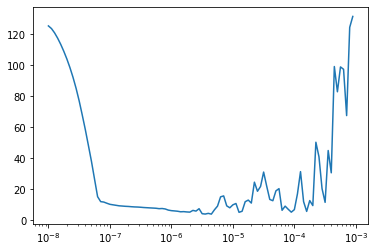

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
20/20 [==============================] - 5s 36ms/step - loss: 37.0250 - mae: 37.5198
Epoch 2/150
20/20 [==============================] - 1s 36ms/step - loss: 6.8989 - mae: 7.3574
Epoch 3/150
20/20 [==============================] - 1s 36ms/step - loss: 5.0947 - mae: 5.5298
Epoch 4/150
20/20 [==============================] - 1s 38ms/step - loss: 3.2781 - mae: 3.7332
Epoch 5/150
20/20 [==============================] - 1s 38ms/step - loss: 2.8850 - mae: 3.3414
Epoch 6/150
20/20 [==============================] - 1s 38ms/step - loss: 2.4645 - mae: 2.9182
Epoch 7/150
20/20 [==============================] - 1s 38ms/step - loss: 2.4675 - mae: 2.9270
Epoch 8/150
20/20 [==============================] - 1s 41ms/step - loss: 2.0144 - mae: 2.4663
Epoch 9/150
20/20 [==============================] - 1s 40ms/step - loss: 1.9274 - mae: 2.3714
Epoch 10/150
20/20 [==============================] - 1s 39ms/step - loss: 2.0406 - mae: 2.4993
Epoch 11/150
20/20 [===========================

In [28]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

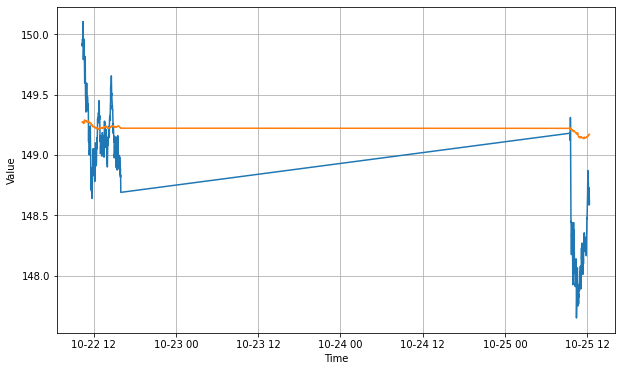

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.172106

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS